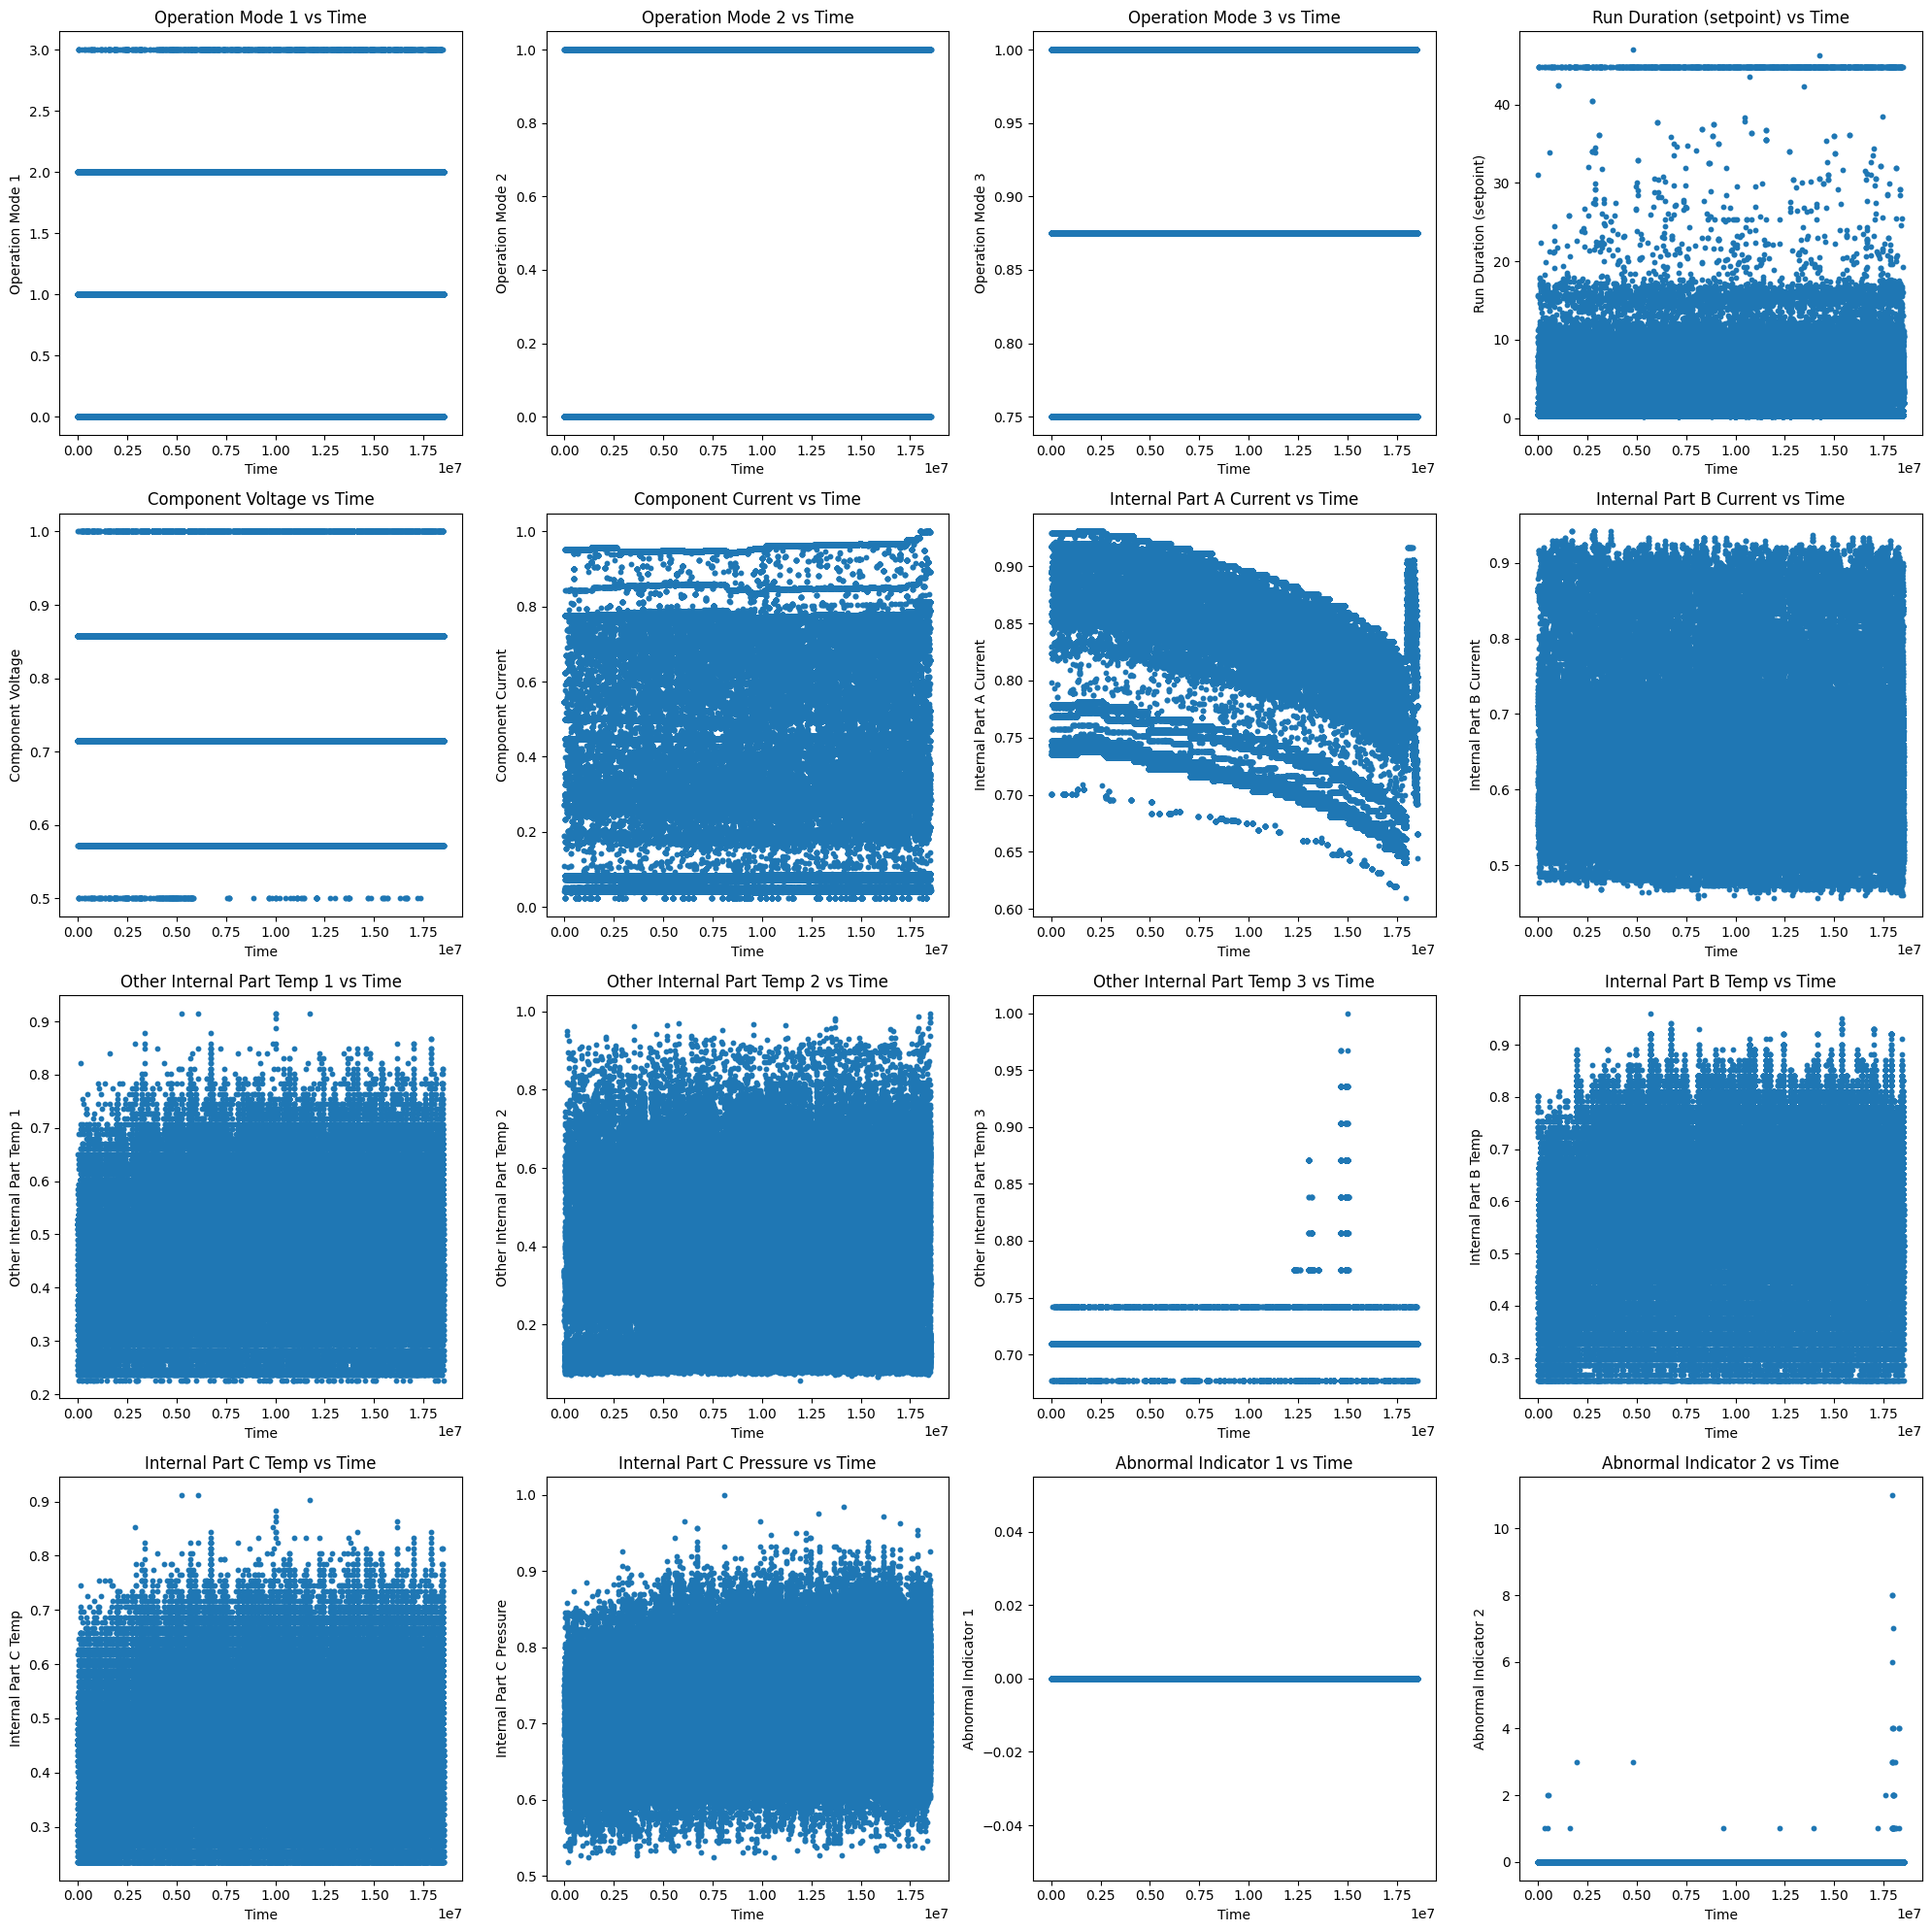

In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns

tube = pd.read_csv('tube3.csv')
feature_names = {
    'f1':  'Time',
    'f2':  'Sample Count',
    'f3':  'Operation Mode 1',
    'f4':  'Operation Mode 2',
    'f5':  'Operation Mode 3',
    'f6':  'Run Duration (setpoint)',
    'f7':  'Component Voltage',
    'f8':  'Component Current',
    'f9':  'Internal Part A Current',
    'f10': 'Internal Part B Current',
    'f11': 'Other Internal Part Temp 1',
    'f12': 'Other Internal Part Temp 2',
    'f13': 'Other Internal Part Temp 3',
    'f14': 'Internal Part B Temp',
    'f15': 'Internal Part C Temp',
    'f16': 'Internal Part C Pressure',
    'f17': 'Abnormal Indicator 1',
    'f18': 'Abnormal Indicator 2',
}

features_to_clean = [f'f{i}' for i in range(7, 17)]

# 使用布尔索引逐个特征过滤掉 0 和负值
cleaned_tube1 = tube.copy()

def clean_data(data, features_to_clean):
    for feat in features_to_clean:
        data = data[data[feat] > 0]
    return data


# 2. Plot f3–f18 vs. cycle (assuming cycle is in column 'f1')
def plot_features_over_cycles(data, features, cycle_col='f1'):
    fig, axes = plt.subplots(4, 4, figsize=(20, 20))
    axes = axes.flatten()
    
    for i, feat in enumerate(features):
        ax = axes[i]
        ax.scatter(data[cycle_col], data[feat], s=10)
        ax.set_xlabel(feature_names[cycle_col])
        ax.set_ylabel(feature_names[feat])
        ax.set_title(f"{feature_names[feat]} vs {feature_names[cycle_col]}")
    
    # Hide any unused subplots
    for j in range(len(features), len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.savefig('features_over_cycles.png')
    plt.show()

features = [f'f{i}' for i in range(3, 19)]
# plot_features_over_cycles(cleaned_tube1,features)



# 3. Correlation heatmap with 2‑decimal annotations and English labels
def plot_correlation_heatmap(data, label):
    plt.figure(figsize=(12, 10))
    corr = data.corr()
    # Rename rows & columns to English names
    corr.index = [feature_names.get(c, c) for c in corr.index]
    corr.columns = [feature_names.get(c, c) for c in corr.columns]
    
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
    plt.title(f'{label} – Correlation Heatmap')
    plt.savefig(f'{label}_correlation_heatmap.png')
    plt.show()

# plot_correlation_heatmap(cleaned_tube1, 'Tube1')


# 4. Boxplots for a selected subset (in English)
def plot_boxplots(data, features, label):
    plt.figure(figsize=(12, 6))
    # Rename to English
    df = data[features].rename(columns=feature_names)
    sns.boxplot(data=df)
    plt.xticks(rotation=45, ha='right')
    plt.title(f'{label} – Boxplots')
    plt.tight_layout()
    plt.savefig(f'{label}_boxplots.png')
    plt.show()

selected_features = ['f7','f8','f9','f10','f11','f12','f13','f14','f15','f16']

cleaned_tube1 = clean_data(tube, features_to_clean)
plot_features_over_cycles(cleaned_tube1,features)

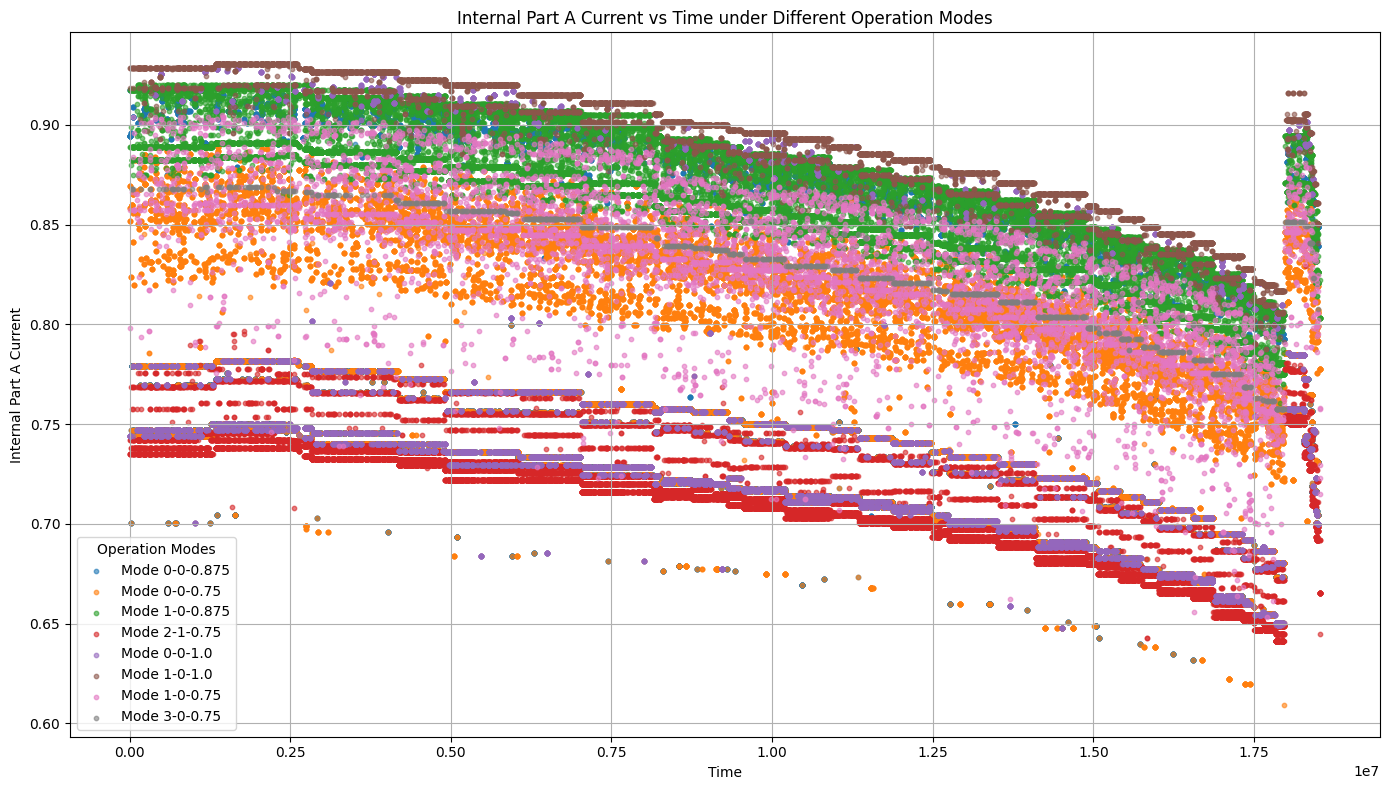

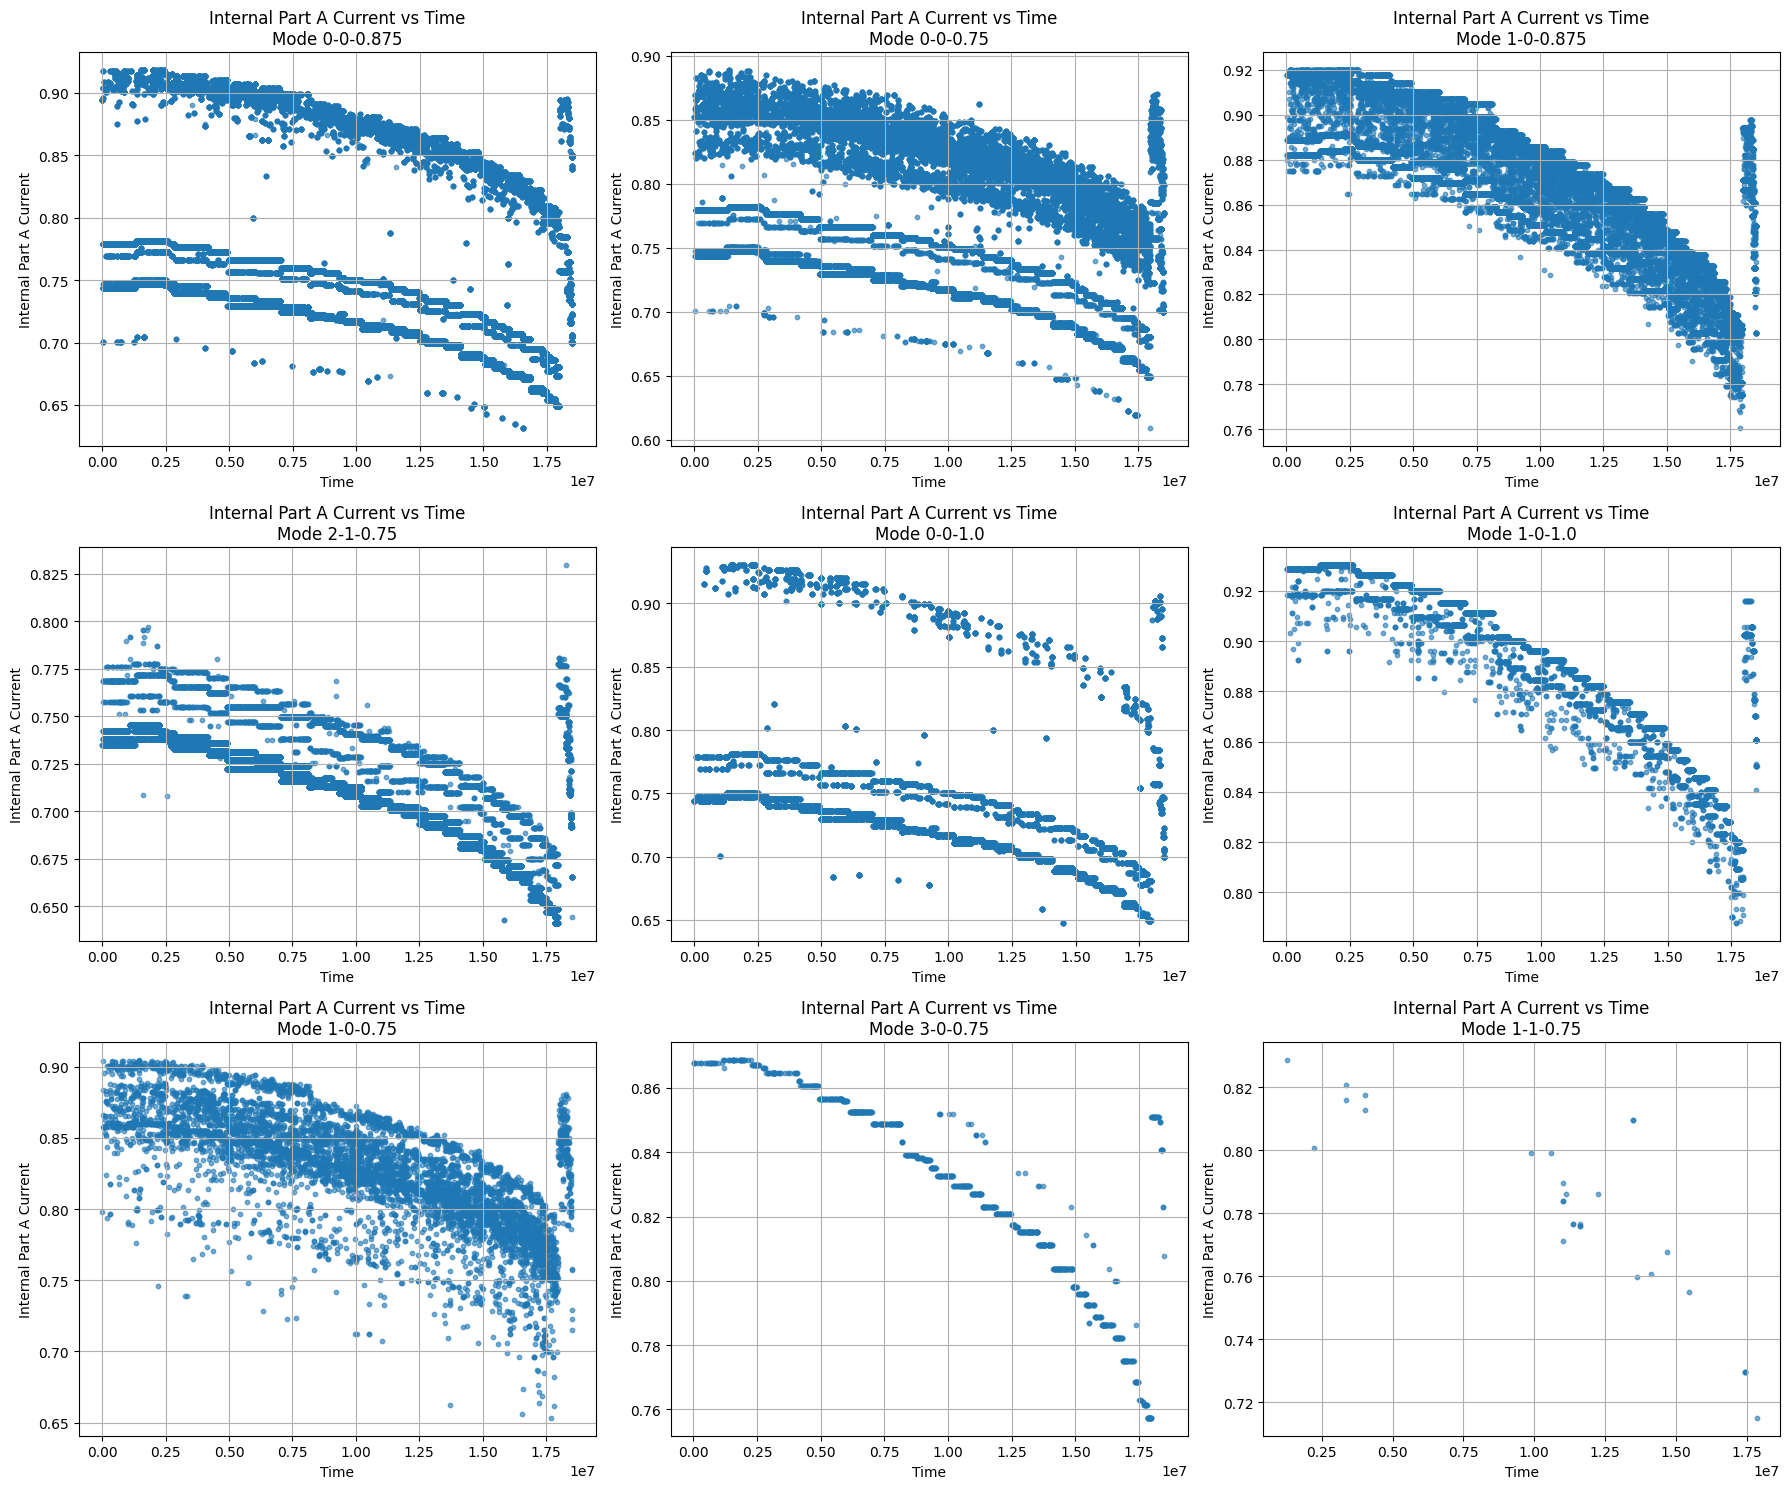

In [4]:
cleaned_tube1['Operation Mode Combination'] = (
    cleaned_tube1['f3'].astype(str) + '-' +
    cleaned_tube1['f4'].astype(str) + '-' +
    cleaned_tube1['f5'].astype(str)
)

# 可选：筛选出现次数较多的组合，避免图太乱
mode_counts = cleaned_tube1['Operation Mode Combination'].value_counts()
top_modes = mode_counts[mode_counts > 50].index  # 只保留出现超过 50 次的组合
filtered_data = cleaned_tube1[cleaned_tube1['Operation Mode Combination'].isin(top_modes)]

# 绘图
plt.figure(figsize=(14, 8))
for mode in top_modes:
    subset = filtered_data[filtered_data['Operation Mode Combination'] == mode]
    plt.scatter(subset['f1'], subset['f9'], s=10, label=f'Mode {mode}', alpha=0.6)

plt.xlabel(feature_names['f1'])
plt.ylabel(feature_names['f9'])
plt.title('Internal Part A Current vs Time under Different Operation Modes')
plt.legend(title='Operation Modes')
plt.grid(True)
plt.tight_layout()
plt.savefig("f9_vs_cycle_by_mode.png")
plt.show()



# 创建操作模式组合列
cleaned_tube1['Operation Mode Combination'] = (
    cleaned_tube1['f3'].astype(str) + '-' +
    cleaned_tube1['f4'].astype(str) + '-' +
    cleaned_tube1['f5'].astype(str)
)

# 选出频次最多的前 9 个模式组合
top_modes = cleaned_tube1['Operation Mode Combination'].value_counts().nlargest(9).index
filtered_data = cleaned_tube1[cleaned_tube1['Operation Mode Combination'].isin(top_modes)]

# 创建子图
n = len(top_modes)
rows = (n + 2) // 3  # 每行最多 3 个子图
fig, axes = plt.subplots(rows, 3, figsize=(18, 5 * rows))
axes = axes.flatten()

# 绘图
for i, mode in enumerate(top_modes):
    ax = axes[i]
    subset = filtered_data[filtered_data['Operation Mode Combination'] == mode]
    ax.scatter(subset['f1'], subset['f9'], s=10, alpha=0.6)
    ax.set_title(f'Internal Part A Current vs Time\nMode {mode}')
    ax.set_xlabel(feature_names['f1'])
    ax.set_ylabel(feature_names['f9'])
    ax.grid(True)

# 隐藏多余子图
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.savefig("f9_vs_time_by_modes_subplots.png")
plt.show()

模式 1-0-0.875 的数据量: 52946


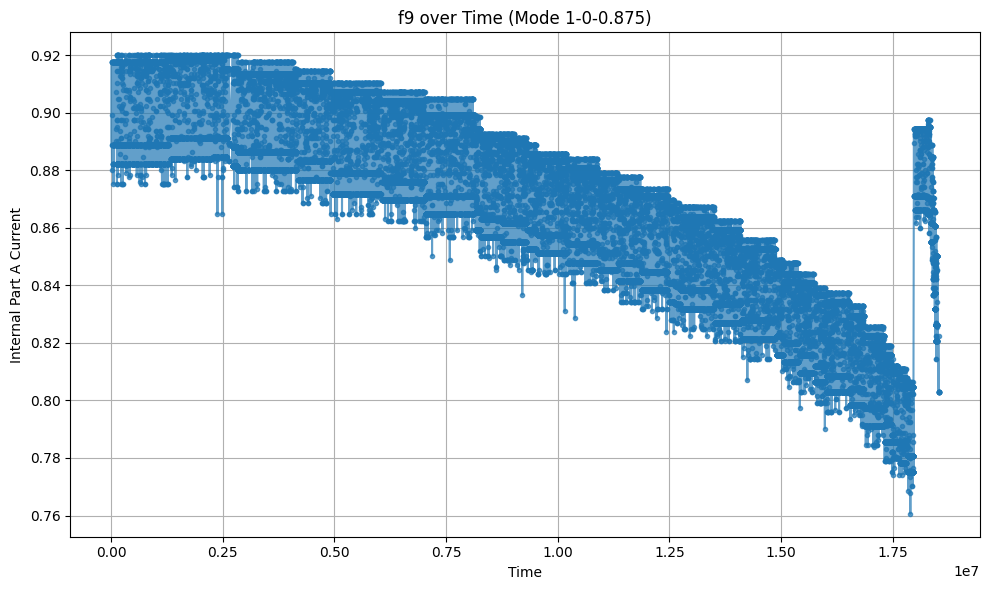

In [5]:
mode_target = '1-0-0.875'
mode_data = cleaned_tube1[cleaned_tube1['Operation Mode Combination'] == mode_target].copy()
mode_data.to_csv("tube3_mode_1-0-0.875.csv", index=False)
print(f"模式 {mode_target} 的数据量: {len(mode_data)}")
plt.figure(figsize=(10, 6))
plt.plot(mode_data['f1'], mode_data['f9'], marker='o', linestyle='-', markersize=3, alpha=0.7)
plt.title(f'f9 over Time (Mode {mode_target})')
plt.xlabel(feature_names['f1'])
plt.ylabel(feature_names['f9'])
plt.grid(True)
plt.tight_layout()
plt.savefig("f9_trend_mode_1-0-0.875.png")
plt.show()


In [8]:
import numpy as np

def build_sequences(data, input_len=30, pred_len=1):
    sequences, labels = [], []
    values = data['f9'].values  # 可改为多特征 values = data[['f9', 'f6', ...]].values
    for i in range(len(values) - input_len - pred_len):
        sequences.append(values[i:i+input_len])
        labels.append(values[i+input_len + pred_len - 1])  # 预测未来值
    return np.array(sequences), np.array(labels)

X, y = build_sequences(mode_data, input_len=30)


In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import Dataset, DataLoader

# 读取筛选后的数据（或直接使用 mode_data）
df = mode_data.sort_values(by='f1')  # 时间升序

# 只使用 f9，后续可扩展为多维输入
scaler = MinMaxScaler()
f9_scaled = scaler.fit_transform(df[['f9']].values)

# 构建序列
def build_sequences(data, input_len=30):
    X, y = [], []
    for i in range(len(data) - input_len):
        X.append(data[i:i+input_len])
        y.append(data[i+input_len])
    return np.array(X), np.array(y)

X, y = build_sequences(f9_scaled, input_len=30)

In [10]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

dataset = TimeSeriesDataset(X, y)
train_loader = DataLoader(dataset, batch_size=64, shuffle=True)


In [11]:
import torch.nn as nn

class CNNLSTM(nn.Module):
    def __init__(self, input_dim=1, cnn_channels=32, lstm_hidden=64):
        super(CNNLSTM, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=input_dim, out_channels=cnn_channels, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv1d(cnn_channels, cnn_channels, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.lstm = nn.LSTM(input_size=cnn_channels, hidden_size=lstm_hidden, batch_first=True)
        self.fc = nn.Linear(lstm_hidden, 1)

    def forward(self, x):  # x: [batch, time, feature]
        x = x.permute(0, 2, 1)          # → [batch, 1, time]
        x = self.cnn(x)                 # → [batch, cnn_channels, time]
        x = x.permute(0, 2, 1)          # → [batch, time, cnn_channels]
        _, (hn, _) = self.lstm(x)       # hn: [1, batch, hidden]
        out = self.fc(hn[-1])           # [batch, 1]
        return out


In [12]:
model = CNNLSTM().to('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

device = next(model.parameters()).device

for epoch in range(50):
    model.train()
    total_loss = 0
    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        optimizer.zero_grad()
        output = model(batch_x).squeeze()
        loss = criterion(output, batch_y.squeeze())
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")


Epoch 1, Loss: 7.7005
Epoch 2, Loss: 2.0398
Epoch 3, Loss: 1.9790
Epoch 4, Loss: 1.9554
Epoch 5, Loss: 1.9496
Epoch 6, Loss: 1.9402
Epoch 7, Loss: 1.9650
Epoch 8, Loss: 1.9241
Epoch 9, Loss: 1.9423
Epoch 10, Loss: 1.9259
Epoch 11, Loss: 1.9170
Epoch 12, Loss: 1.9418
Epoch 13, Loss: 1.9195
Epoch 14, Loss: 1.9263
Epoch 15, Loss: 1.9029
Epoch 16, Loss: 1.8962
Epoch 17, Loss: 1.9241
Epoch 18, Loss: 1.9073
Epoch 19, Loss: 1.8993
Epoch 20, Loss: 1.9031
Epoch 21, Loss: 1.9119
Epoch 22, Loss: 1.8834
Epoch 23, Loss: 1.8919
Epoch 24, Loss: 1.8931
Epoch 25, Loss: 1.8796
Epoch 26, Loss: 1.9081
Epoch 27, Loss: 1.8771
Epoch 28, Loss: 1.8839
Epoch 29, Loss: 1.8658
Epoch 30, Loss: 1.8897
Epoch 31, Loss: 1.8887
Epoch 32, Loss: 1.8691
Epoch 33, Loss: 1.8747
Epoch 34, Loss: 1.8855
Epoch 35, Loss: 1.8540
Epoch 36, Loss: 1.8615
Epoch 37, Loss: 1.8717
Epoch 38, Loss: 1.8606
Epoch 39, Loss: 1.8649
Epoch 40, Loss: 1.8722
Epoch 41, Loss: 1.8551
Epoch 42, Loss: 1.8566
Epoch 43, Loss: 1.8511
Epoch 44, Loss: 1.85

In [13]:
# 取最近 30 步预测下一步 f9
model.eval()
with torch.no_grad():
    recent_sequence = torch.tensor(f9_scaled[-30:], dtype=torch.float32).unsqueeze(0).to(device)  # [1, 30, 1]
    prediction = model(recent_sequence).cpu().numpy()
    f9_pred = scaler.inverse_transform(prediction.reshape(-1, 1))[0][0]
    print(f"Predicted next f9: {f9_pred:.4f}")


Predicted next f9: 0.7886
